In [1]:
# for drawing graphs from pyBBN network
import pandas as pd
!pip install pybbn
import networkx as nx

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40372 sha256=379f1f1211e60684e9bfe2a7e55b0ba45838c09dea1999644c477818999b4884
  Stored in directory: /root/.cache/pip/wheels/97/20/85/52b65994184561eecc73318b47effb93e250a3dc3264db32c9
Successfully built pybbn


In [2]:
# Read in the weather data csv
data=pd.read_csv('/content/weatherAUS_cleaned.csv',encoding='utf-8')
# see weather csv
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustSpeedCat,Humidity9amCat,Humidity3pmCat
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,...,1007.1,8.000000,4.503167,16.9,21.8,No,No,1.40-50,1.>60,0.<=60
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,...,1007.8,4.437189,4.503167,17.2,24.3,No,No,1.40-50,0.<=60,0.<=60
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,...,1008.7,4.437189,2.000000,21.0,23.2,No,No,1.40-50,0.<=60,0.<=60
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,...,1012.8,4.437189,4.503167,18.1,26.5,No,No,0.<=40,0.<=60,0.<=60
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,...,1006.0,7.000000,8.000000,17.8,29.7,No,No,1.40-50,1.>60,0.<=60


In [3]:
# data shape
data.shape

(142193, 26)

In [4]:
# see data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              142193 non-null  object 
 1   Location          142193 non-null  object 
 2   MinTemp           142193 non-null  float64
 3   MaxTemp           142193 non-null  float64
 4   Rainfall          142193 non-null  float64
 5   Evaporation       142193 non-null  float64
 6   Sunshine          142193 non-null  float64
 7   WindGustDir       132863 non-null  object 
 8   WindGustSpeed     142193 non-null  float64
 9   WindDir9am        132180 non-null  object 
 10  WindDir3pm        138415 non-null  object 
 11  WindSpeed9am      142193 non-null  float64
 12  WindSpeed3pm      142193 non-null  float64
 13  Humidity9am       142193 non-null  float64
 14  Humidity3pm       142193 non-null  float64
 15  Pressure9am       142193 non-null  float64
 16  Pressure3pm       14

In [5]:
# null values
data.isna().sum()

,0
Date,0
Location,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustDir,9330
WindGustSpeed,0
WindDir9am,10013


In [6]:
# Drop records where target RainTomorrow=NaN
data=data[data.RainTomorrow.isna()==False]

# Select only numerical columns for mean imputation
numerical_cols = data.select_dtypes(include=['float', 'int']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())  # fill numerical column with their means

In [7]:
# see null again
data.isna().sum()

,0
Date,0
Location,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustDir,9330
WindGustSpeed,0
WindDir9am,10013


In [8]:
# Create bands for variables that we want to use in the model
data['WindGustSpeedCat']=data['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else '1.40-50' if 40<x<=50 else '2.>50')
data['Humidity9amCat']=data['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
data['Humidity3pmCat']=data['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
data[['WindGustSpeed','WindGustSpeedCat',
      'Humidity9am','Humidity9amCat',
      'Humidity3pm','Humidity3pmCat']].head()

,WindGustSpeed,WindGustSpeedCat,Humidity9am,Humidity9amCat,Humidity3pm,Humidity3pmCat
0,44.0,1.40-50,71.0,1.>60,22.0,0.<=60
1,44.0,1.40-50,44.0,0.<=60,25.0,0.<=60
2,46.0,1.40-50,38.0,0.<=60,30.0,0.<=60
3,24.0,0.<=40,45.0,0.<=60,16.0,0.<=60
4,41.0,1.40-50,82.0,1.>60,33.0,0.<=60


In [9]:
prob_columns=['WindGustSpeedCat','Humidity9amCat','Humidity3pmCat']
# see probabilites
for colmn in prob_columns:
  print(data[colmn].value_counts().sort_index())

WindGustSpeedCat
0.<=40     83410
1.40-50    34183
2.>50      24600
Name: count, dtype: int64
Humidity9amCat
0.<=60    43594
1.>60     98599
Name: count, dtype: int64
Humidity3pmCat
0.<=60    95446
1.>60     46747
Name: count, dtype: int64


In [10]:
prob_columns=['WindGustSpeedCat','Humidity9amCat','Humidity3pmCat']
# see probabilites
for colmn in prob_columns:
  print(data[colmn].value_counts(normalize=True).sort_index())

WindGustSpeedCat
0.<=40     0.586597
1.40-50    0.240399
2.>50      0.173004
Name: proportion, dtype: float64
Humidity9amCat
0.<=60    0.306583
1.>60     0.693417
Name: proportion, dtype: float64
Humidity3pmCat
0.<=60    0.671243
1.>60     0.328757
Name: proportion, dtype: float64


In [11]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
# prevent from multiple probability calculation --> calculating probabilities/frequencies of “H3pm” twice — the first
# time by taking a subset of data where “H9am”≤60 and the second time by taking a subset of data where “H9am”>60.

def probs(data, child, parent1=None, parent2=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        prob=data[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Work out the bands present in the parent variable
                bands=data[parent1].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp=data[data[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                    prob=prob+temp
            else:
                # Work out the bands present in the parent variable
                bands1=data[parent1].value_counts(sort=False).sort_index().index.tolist()
                bands2=data[parent2].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val1 in bands1:
                    for val2 in bands2:
                        temp=data[(data[parent1]==val1) & (data[parent2]==val2)][child].value_counts(normalize=True).sort_index().tolist()
                        prob=prob+temp
    else: print("Error in Probability Frequency Calculations")
    return prob

In [12]:
# Create nodes by manually typing in probabilities

# humidity at 9 am
H9am=BbnNode(Variable(0,'H9am',['<=60','>60']),[0.30658,0.69342])
# humidity at 3 pm
H3pm=BbnNode(Variable(1,'H3pm',['<=60','>60']),[0.92827,0.07173,0.55760,0.44240])
# wind speed
W=BbnNode(Variable(2,'W',['<=40','40-50','>50']),[0.58660,0.24040,0.17300])
# rain tomorrow
RT=BbnNode(Variable(3,'RT',['No','Yes']),[0.92314,0.07686,0.89072, 0.10928,0.76008,0.23992,
                                          0.64250,0.35750,0.49168,0.50832,0.32182,0.67818])

In [13]:
# Create Network
bbn_network=Bbn()
# add nodes
bbn_network.add_node(H9am)
bbn_network.add_node(H3pm)
bbn_network.add_node(W)
bbn_network.add_node(RT)
# add edges
bbn_network.add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED))
bbn_network.add_edge(Edge(H3pm, RT, EdgeType.DIRECTED))
bbn_network.add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
bbn_network_tree=InferenceController.apply(bbn_network)

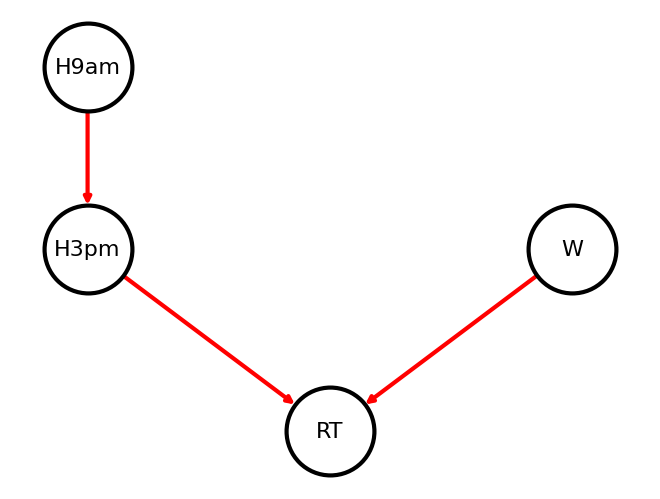

In [14]:
# Set node positions
import matplotlib.pyplot as plt
pos={0:(-1,2),1:(-1,0.5),2:(1,0.5),3:(0, -1)}

# Set options for graph looks
options={"font_size": 16,"node_size": 4000,"node_color":"white",
         "edgecolors":"black","edge_color":"red","linewidths":3,"width":3,}

# Generate graph
bbn_nx_graph,bbn_node_labels=bbn_network.to_nx_graph()
nx.draw(bbn_nx_graph,with_labels=True,labels=bbn_node_labels,pos=pos,**options)

# Update margins and print the graph
ax=plt.gca()  # get current working axis
ax.margins(0.10) # set margin
plt.axis("off") # make x and y axis off
# show plot
plt.show()

RT: Represents "Rain Tomorrow" and has states 'No' and 'Yes'.
W: Represents "Wind" and has states '<=40', '40-50', and '>50'.
H9am: Represents "Humidity at 9 am" and has states '<=60' and '>60'.

In [15]:
# Define a function for printing marginal probabilities
def print_probs(tree_name):
  for node in tree_name.get_bbn_nodes():
    potential=tree_name.get_bbn_potential(node)
    print('Node -> ',node)
    print('Values -> ')
    print(potential)
    print('--------X--------')

# Use the above function to print marginal probabilities
print_probs(tree_name=bbn_network_tree)

Node ->  1|H3pm|<=60,>60
Values -> 
1=<=60|0.67124
1=>60|0.32876
--------X--------
Node ->  0|H9am|<=60,>60
Values -> 
0=<=60|0.30658
0=>60|0.69342
--------X--------
Node ->  2|W|<=40,40-50,>50
Values -> 
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
--------X--------
Node ->  3|RT|No,Yes
Values -> 
3=No|0.77655
3=Yes|0.22345
--------X--------


In [16]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(tree_,node,node_catgr,value):
  bbn_ebuilder=EvidenceBuilder()
  bbn_ebuilder.with_node(tree_.get_bbn_node_by_name(node)) # bbn_ebuilder.with_node(node_number)
  bbn_ebuilder.with_evidence(node_catgr,value)
  # update network
  bbn_ebuilder_built_=bbn_ebuilder.build()
  tree_.set_observation(bbn_ebuilder_built_)

# Use above function to add evidence
evidence(bbn_network_tree,'H9am','>60',1.0)

# Print marginal probabilities
print_probs(bbn_network_tree)

Node ->  1|H3pm|<=60,>60
Values -> 
1=<=60|0.55760
1=>60|0.44240
--------X--------
Node ->  0|H9am|<=60,>60
Values -> 
0=<=60|0.00000
0=>60|1.00000
--------X--------
Node ->  2|W|<=40,40-50,>50
Values -> 
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
--------X--------
Node ->  3|RT|No,Yes
Values -> 
3=No|0.73833
3=Yes|0.26167
--------X--------


In [19]:


# Print marginal probabilities after adding evidence
print_probs(tree_name=bbn_network_tree)

#RT: Represents "Rain Tomorrow" and has states 'No' and 'Yes'. W: Represents "Wind" and has states '<=40', '40-50', and '>50'. H9am: Represents "Humidity at 9 am" and has states '<=60' and '>60'.
'''0: H9am (Humidity at 9 am)
1: H3pm (Humidity at 3 pm)
2: W (Wind Gust Speed)
3: RT (Rain Tomorrow)
'''

Node ->  1|H3pm|<=60,>60
Values -> 
1=<=60|0.55760
1=>60|0.44240
--------X--------
Node ->  0|H9am|<=60,>60
Values -> 
0=<=60|0.00000
0=>60|1.00000
--------X--------
Node ->  2|W|<=40,40-50,>50
Values -> 
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
--------X--------
Node ->  3|RT|No,Yes
Values -> 
3=No|0.73833
3=Yes|0.26167
--------X--------
